Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/FTRCE/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Compute the maximum_a_posteriori

In [7]:
maximum_a_posteriori(model, lb, ub)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.3154393854875168]
 * Minimizer: [0.6666666665303277]
 * Minimum: 1.297811e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.17e-07 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.14e-13 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 4.76e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 49
 * Gradient Calls: 49

Use Turing mcmc

In [8]:
chn = sample(model, Turing.NUTS(2000, 1000, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 3.2
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:235
┌ Warning: 9.815057842449812 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.385813986150353 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.316211179689477 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.159499778816516 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/s

Fix the inclusion of adaptation samples

In [9]:
chn2 = MCMCChain.Chains(chn.value[1001:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Union{Missing, Float64}[0.0 0.042653913 … 10.0 0.8851422413177973; 0.0 0.000343306 … 4.0 0.8851422413177973; … ; 0.0 0.000349299 … 10.0 0.8851422413177973; 0.0 0.000343493 … 10.0 0.8851422413177973]

Look at the proper draws (in corrected chn2)

In [10]:
describe(chn2)

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
              Mean                 SD                    Naive SE              MCSE         ESS   
  lf_num  0.00000000000 0.0000000000000000000000 0.0000000000000000000000 0.000000000000       NaN
 elapsed  0.00032321643 0.0013770106864494050403 0.0000435449013157207838 0.000047261613  848.9020
 epsilon  0.88514224132 0.0000000000000011107786 0.0000000000000000351259 0.000000000000 1000.0000
   theta  0.62842661862 0.1355603409089954913824 0.0042867943766132605640 0.003716661629 1000.0000
      lp -3.27132445320 0.7288312707793795919287 0.0230476684561776307136 0.038015343094  367.5667
eval_num  7.26400000000 2.9898567262066664262932 0.0945475713238750903322 0.069397406292 1000.0000
  lf_eps  0.88514224132 0.0000000000000011107786 0.0000000000000000351259 0.000000000000 1000.0000

Quantiles:
              2.5%        25.0%        50.0%        75.0%        97.5%    
  lf_num  0

Compute at hpd region

In [11]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

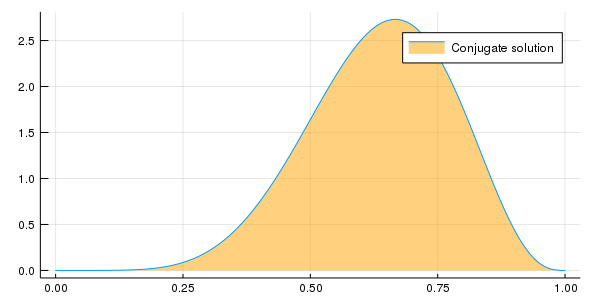

In [12]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

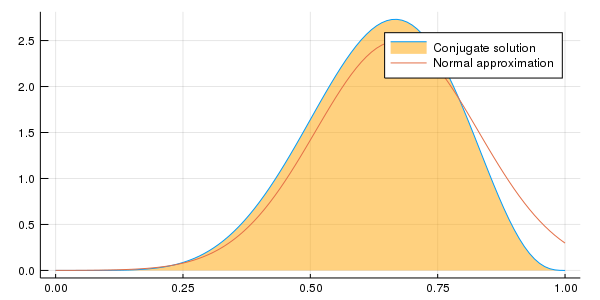

In [13]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

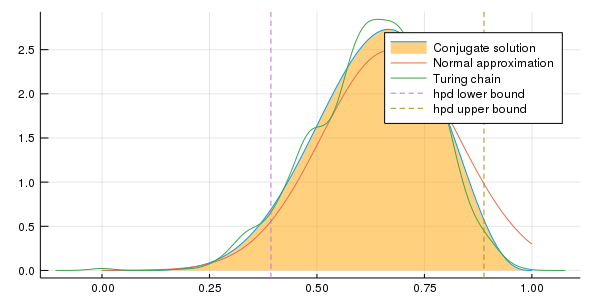

In [14]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [15]:
println("hpd bounds = $bnds\n")

hpd bounds =        94% Lower  94% Upper
theta 0.39296046 0.88849750





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*